In [77]:
# this note book contain the implementation code for sharing problem in admm
# problem: minimize sum f_i(xi) + sigma*norm1(sum x_i)

In [78]:
# data loading function x

In [79]:
import scipy
import numpy as np

In [80]:
data = scipy.io.loadmat(".//data//10 Agents//p5//Set1")

In [81]:
#extract data
gamma = data['Phi'][0] ## function hessian (include 10: 5x5 matrix)
theta = data['theta'][0] ## theta fi_xi = (xi-theta_i) @ phi @ (xi-theta)
# J_solver = data['J_solver'] 
solution = data['solution']

In [82]:
theta[0].shape[0]

5

In [83]:
gamma

array([array([[ 3.05271894,  0.00511058,  0.75442126,  0.10518988,  0.39036285],
              [ 0.00511058,  1.2829242 ,  0.31232697, -0.23996578,  0.16239734],
              [ 0.75442126,  0.31232697,  2.35086902,  0.16726005,  0.02007351],
              [ 0.10518988, -0.23996578,  0.16726005,  3.4452551 ,  0.2774467 ],
              [ 0.39036285,  0.16239734,  0.02007351,  0.2774467 ,  1.44179101]]),
       array([[ 1.8543407 ,  0.29833952, -0.93124254,  0.43258215,  0.1533364 ],
              [ 0.29833952,  2.96153576,  0.58298475,  0.14334996,  0.05268313],
              [-0.93124254,  0.58298475,  3.04529189,  0.52067856,  0.04610029],
              [ 0.43258215,  0.14334996,  0.52067856,  3.00197641,  0.05121138],
              [ 0.1533364 ,  0.05268313,  0.04610029,  0.05121138,  2.77931379]]),
       array([[ 2.25733269, -0.27961669, -0.41232016,  0.43519568, -0.44246965],
              [-0.27961669,  3.44965339,  0.55044586,  0.2410538 ,  0.83532871],
              [-0.412320

In [84]:
len(gamma)

10

In [85]:
np.linalg.eigvals(gamma[0])

array([3.75700541, 3.34843866, 1.99678225, 1.        , 1.47133195])

In [86]:
# checking eigenvalue to ensure input matrix is PSD
for i in range (len(gamma)):
    eighen_val = np.linalg.eigvals(gamma[i])
    if np.all(eighen_val >= 0):
        print(f"Input matrix {i} satisfy")
    else:
        print(f"Input matrix %s DOES not satisfy",i)



Input matrix 0 satisfy
Input matrix 1 satisfy
Input matrix 2 satisfy
Input matrix 3 satisfy
Input matrix 4 satisfy
Input matrix 5 satisfy
Input matrix 6 satisfy
Input matrix 7 satisfy
Input matrix 8 satisfy
Input matrix 9 satisfy


In [87]:
# stopping criteria
primal_residual = 1e-4
dual_residual = 1e-3

## Problem

Consider the sharing problem of ADMM, perform with n agents collaborate to solve the global optimization problem as bellow. where the $x_i \in R^n$ and hessian matrix $\Gamma_i \in R^{n x n}$, consider the $z_i$ is copy of $x_i$. The ADMM form of the problem can be written as:

\begin{aligned}
\min_{\{x_i,z_i\}} \quad 
& \sum_{i=1}^n (x_i-\theta_i)^\top \Gamma_i (x_i-\theta_i)
\;+\; \zeta\left\|\sum_{i=1}^n z_i\right\|_1 \\
\text{s.t.}\quad & x_i - z_i = 0,\qquad i=1,\dots,n.
\end{aligned}

Here the $g(x_i)$ is the shared objective of our problem, $f_i(x_i)$ is the local cost function. Then the augumented largrangian function is considered as:

In [89]:
# set the soft function to solve the z-update

def soft_threshold(v, tau):
    return np.sign(v) * np.maximum(np.abs(v) - tau, 0)

In [90]:
def cho_solve(L, b):
    # solving linear system of x by cholesky decomp (L @ L^T) x = b
    y = np.linalg.solve(L, b)
    return np.linalg.solve(L.T, y)

In [91]:
def stack_norm_sq(vecs):
    # norm 2 of a big vec
    return sum(np.dot(v, v) for v in vecs)

### Define the solver ADMM

In [93]:
class Sharing_ADMM_L1Norm:
    def __init__(self, gamma_list, theta_list, zeta=1.0, rho=1.0, eps_abs=1e-4, eps_rel=1e-3, max_iters=300):
        """
        input: 
        + gamma: list of pxp PSD matrix
        + theta: coresponding theta
        + zeta: l1 weight
        + rho: penalty for the augumented part
        """
        self.N = len(gamma_list)
        assert self.N == len(theta_list), "number of theta and gamma missmach"
        self.p = theta_list[0].shape[0] #dimension input

        #store data
        self.G = [np.array(Gi, dtype=float) for Gi in gamma_list]
        self.theta = [np.array(ti, dtype=float).reshape(-1) for ti in theta_list]
        self.residual_storage = []

        # hyper-params:
        self.zeta = float(zeta)
        self.rho = float(rho)
        self.eps_abs  = float(eps_abs)
        self.eps_rel  = float(eps_rel)
        self.max_iters = int(max_iters)

        # variable:
        self.x = [np.zeros(self.p) for _ in range(self.N)] #store solution each iteration
        self.z_blocks = [np.zeros(self.p) for _ in range(self.N)] #set the z as zeros so we basically can using
        # the form of the mean for z update naturally at the first place but if not -> we need to do the first iteration
        # for update the x based on the modeling 
        self.u_shared = np.zeros(self.p) #used when k >= 1 

        self.u_blocks0 = [np.zeros(self.p) for _ in range(self.N)] #use only for k = 0

        self.z_global = np.zeros(self.p) #aggregated z

        # does not change the rho so we can store the cholesky decomp
        I = np.eye(self.p)
        self.L = []

        for i in range(self.N):
            Ai = 2.0 * self.G[i] + self.rho * I ## as when solving the linear system of the optimizing the x
            self.L.append(np.linalg.cholesky(Ai))

    # since the admm with the random initialize of the 
    def first_iter(self):
        # at the first iteration the update of x with the average value will not suitable hence we will optimize the x_i through normal
        N, rho = self.N, self.rho

        # x^i(k+1) -> sovlve (2G + rho*I)@x^k = 2G * theta + rho*(z_ik - u_ik)
        for i in range(N):
            rhs = 2.0 * self.G[i] @ self.theta[i] + rho * (self.z_blocks[i] - self.u_blocks0[i])
            self.x[i] = cho_solve(self.L[i], rhs) #apply cho solve to solve the linear system

        #calculate the z_bar
        a = [self.x[i] + self.u_blocks0[i] for i in range(N)]
        a_bar = sum(a) / N

        # adapt the soft thresholding to solve the proximal problem
        tau = self.zeta / rho
        self.z_global = soft_threshold(a_bar, tau)

        for i in range(N):
            self.z_blocks[i] = a[i] + (self.z_global - a_bar) # calculate each z_ik after solving the minimizer of g(n*z_bar) (7.13)

        self.u_shared = a_bar - self.z_global #update the global multiplier


    def step(self):
        """Continue with the x update using the mean formular"""
        N, rho = self.N, self.rho

        # x_update -> solve: (2*G + rho*I)@x_k+1 = 2*G@theta + rho(x_ik + z_bar_k - x_bar_k - u_bar_k)
        x_bar = sum(self.x)/N

        for i in range(N):
            rhs = 2.0 * self.G[i] @ self.theta[i] + rho * (self.x[i] + self.z_global - x_bar - self.u_shared)
            self.x[i] = cho_solve(self.L[i], rhs) #solving linear system for update x_i(k+1)

        #update z^(k+1): prox the average of a_i = x_i^k+1 + u^k
        a = [self.x[i] + self.u_shared for i in range(N)] #using ushare since all the agetns shared the same u
        a_bar = sum(a) / N

        #update the z_bar same as before
        tau = self.zeta / rho
        self.z_global = soft_threshold(a_bar, tau)

        #recover the block z_i for each agents
        for i in range(N):
            self.z_blocks[i] = a[i] + (self.z_global - a_bar)

        self.u_shared = a_bar - self.z_global

    def compute_eps_pri(self, xnorm, znorm):
        #primal tolerance
        return (self.N * self.p) ** 0.5 * self.eps_abs + self.eps_rel * max(xnorm, znorm)

    def compute_eps_dual(self, unorm):
        #dual tolerances
        return (self.N * self.p) ** 0.5 * self.eps_abs + self.eps_rel * unorm

    def residuals(self, z_prev_blocks):

        #z_prev_blocks: list of previous z_i (same shapes as self.z_blocks)
        N, rho = self.N, self.rho

        """
        residual = ||x_i(k) - z_i(k)||_2
        dual = rho * ||z - z_prev||_2
        """
        r = np.sqrt(stack_norm_sq([self.x[i] - self.z_blocks[i] for i in range(N)]))
        s = rho * np.sqrt(stack_norm_sq([self.z_blocks[i] - z_prev_blocks[i] for i in range(N)]))

       # xnorm: ||x|| stacked - x in R_(N*p)
       # znorm: ||z|| stacked - z in R_(N*p)
       # unorm: ||rho*u|| stacked - u in R_(N*p)
        xnorm = np.sqrt(stack_norm_sq(self.x))
        znorm = np.sqrt(stack_norm_sq(self.z_blocks))
        unorm = rho * np.sqrt(N) * np.linalg.norm(self.u_shared)
    
        return r, s, xnorm, znorm, unorm

    def solve(self, verbose=True, log_every=1):
        # run admm
        N, p = self.N, self.p

        # run first iter
        self.first_iter()

        # residual after first iter (use the previous z = 0)
        zeros_prev = [np.zeros_like(z_b) for z_b in self.z_blocks]

        r, s, xnorm, znorm, unorm = self.residuals(zeros_prev) #compute the residuals and norm needed to update the tolerance
        # store the current state residual
        self.residual_storage.append(r)

        # compute the eps_pri and eps_dual based on 3.1.1 Boyd book
        eps_pri = self.compute_eps_pri(xnorm, znorm)
        
        eps_dual = self.compute_eps_dual(unorm)

        if verbose:
            print(f"iter {0}: r={r:.3e} - eps_pri {eps_pri:.2e}) and s={s:.3e} - eps_dual {eps_dual:.2e}")

        
        if r <= eps_pri and s <= eps_dual:
            return {
                "iters": 0, "r": r, "s": s, "eps_pri": eps_pri, "eps_dual": eps_dual,
                "x": [xi.copy() for xi in self.x],
                "z_blocks": [zi.copy() for zi in self.z_blocks],
                "z_global": self.z_global.copy(),
                "u": self.u_shared.copy(),
                "rho": self.rho, "zeta": self.zeta, "N": self.N, "p": self.p, "r_history": self.residual_storage
            }
        
        # loop through the maxiter
        
        for k in range(1, self.max_iters + 1):
            z_prev = [zb.copy() for zb in self.z_blocks]
    
            self.step()  # x_update -> z_bar -> u_global
    
            r, s, xnorm, znorm, unorm = self.residuals(z_prev)
            self.residual_storage.append(r)
            
            eps_pri = self.compute_eps_pri(xnorm, znorm)
            eps_dual = self.compute_eps_dual(unorm)
    
            if verbose and (k % log_every == 0 or (r <= eps_pri and s <= eps_dual)):
                print(f"iter {k}: r={r:.3e} - eps_pri {eps_pri:.2e}) and  s={s:.3e} - eps_dual {eps_dual:.2e}")
    
            if r <= eps_pri and s <= eps_dual:
                return {
                    "iters": k, "r": r, "s": s, "eps_pri": eps_pri, "eps_dual": eps_dual,
                    "x": [xi.copy() for xi in self.x],
                    "z_blocks": [zi.copy() for zi in self.z_blocks],
                    "z_global": self.z_global.copy(),
                    "u": self.u_shared.copy(),
                    "rho": self.rho, "zeta": self.zeta, "N": self.N, "p": self.p, "r_history": self.residual_storage
                }
    
        # eeached max iters
        return {
            "iters": max_iters, "r": r, "s": s, "eps_pri": eps_pri, "eps_dual": eps_dual,
            "x": [xi.copy() for xi in self.x],
            "z_blocks": [zi.copy() for zi in self.z_blocks],
            "z_global": self.z_global.copy(),
            "u": self.u_shared.copy(),
            "rho": self.rho, "zeta": self.zeta, "N": self.N, "p": self.p, "r_history": self.residual_storage
        }

In [94]:
N = 10
gamma_list = [gamma[i] for i in range(N)]      
theta_list = [theta[i].reshape(-1) for i in range(N)]

solver = Sharing_ADMM_L1Norm(gamma_list, theta_list, zeta=1.0, rho=10, eps_abs=1e-6, eps_rel=1e-4, max_iters=250)

result = solver.solve(
    verbose=True,
    log_every=1
)

print("\n--- finised ---")
print("iters:", result["iters"])
print("r:", result["r"], " (<= eps_pri:", result["eps_pri"], ")")
print("s:", result["s"], " (<= eps_dual:", result["eps_dual"], ")")
print("z_global:", result["z_global"])

iter 0: r=3.420e-01 - eps_pri 1.31e-04) and s=1.196e+01 - eps_dual 3.49e-04
iter 1: r=8.163e-02 - eps_pri 2.05e-04) and  s=7.811e+00 - eps_dual 4.29e-04
iter 2: r=1.733e-02 - eps_pri 2.56e-04) and  s=5.195e+00 - eps_dual 4.34e-04
iter 3: r=1.853e-02 - eps_pri 2.90e-04) and  s=3.542e+00 - eps_dual 4.22e-04
iter 4: r=1.708e-02 - eps_pri 3.13e-04) and  s=2.490e+00 - eps_dual 4.09e-04
iter 5: r=1.324e-02 - eps_pri 3.30e-04) and  s=1.807e+00 - eps_dual 4.00e-04
iter 6: r=9.677e-03 - eps_pri 3.41e-04) and  s=1.352e+00 - eps_dual 3.93e-04
iter 7: r=6.965e-03 - eps_pri 3.50e-04) and  s=1.038e+00 - eps_dual 3.88e-04
iter 8: r=5.035e-03 - eps_pri 3.56e-04) and  s=8.133e-01 - eps_dual 3.85e-04
iter 9: r=3.685e-03 - eps_pri 3.61e-04) and  s=6.472e-01 - eps_dual 3.83e-04
iter 10: r=2.737e-03 - eps_pri 3.64e-04) and  s=5.208e-01 - eps_dual 3.81e-04
iter 11: r=2.062e-03 - eps_pri 3.67e-04) and  s=4.225e-01 - eps_dual 3.80e-04
iter 12: r=1.572e-03 - eps_pri 3.69e-04) and  s=3.446e-01 - eps_dual 3.79e-

In [95]:
result["x"]

[array([ 0.15778053, -0.57297431, -0.97586966,  0.50040946, -0.14865799]),
 array([-0.1389141 ,  0.08996526,  0.94401342,  0.05513399, -0.27775439]),
 array([ 0.02078361, -0.13790289,  1.13610098, -0.67017721,  0.68254937]),
 array([ 0.4634573 ,  0.22389979, -0.5667521 ,  0.23525933,  0.22513185]),
 array([ 0.29590933, -0.8992399 ,  0.8450037 , -0.35160857, -0.94311579]),
 array([-0.51160225,  0.56711586,  0.74681316, -0.40405267, -0.0080443 ]),
 array([ 0.43343427,  0.83764949, -0.60985014,  0.00909794,  0.54083706]),
 array([-0.18127947, -0.09780837, -0.65471559,  0.27151856, -0.8334769 ]),
 array([-0.38656347, -0.12171485, -0.59996435,  0.31601769,  0.90677495]),
 array([-0.15300513,  0.11101048, -0.264778  ,  0.03840162, -0.14424369])]

In [96]:
result["z_blocks"]

[array([ 0.15778047, -0.57297436, -0.9758698 ,  0.50040944, -0.14865801]),
 array([-0.13891416,  0.0899652 ,  0.94401328,  0.05513397, -0.27775441]),
 array([ 0.02078355, -0.13790295,  1.13610084, -0.67017722,  0.68254935]),
 array([ 0.46345724,  0.22389973, -0.56675224,  0.23525932,  0.22513184]),
 array([ 0.29590927, -0.89923996,  0.84500356, -0.35160858, -0.94311581]),
 array([-0.51160231,  0.56711581,  0.74681301, -0.40405268, -0.00804432]),
 array([ 0.43343421,  0.83764943, -0.60985028,  0.00909793,  0.54083704]),
 array([-0.18127953, -0.09780843, -0.65471573,  0.27151854, -0.83347692]),
 array([-0.38656353, -0.1217149 , -0.59996449,  0.31601768,  0.90677493]),
 array([-0.15300519,  0.11101042, -0.26477814,  0.03840161, -0.14424371])]

In [97]:
result["z_global"]

array([-0.,  0.,  0.,  0.,  0.])

In [98]:
result["u"]

array([-0.09139245,  0.01576021,  0.0216113 ,  0.06351106,  0.02555527])

In [99]:
data["solution"][0]

array([ 0.15778761, -0.13892098,  0.02081964,  0.4634618 ,  0.29590942,
       -0.51165811,  0.43345383, -0.18126754, -0.38657053, -0.15301514])

In [100]:
result["x"]

[array([ 0.15778053, -0.57297431, -0.97586966,  0.50040946, -0.14865799]),
 array([-0.1389141 ,  0.08996526,  0.94401342,  0.05513399, -0.27775439]),
 array([ 0.02078361, -0.13790289,  1.13610098, -0.67017721,  0.68254937]),
 array([ 0.4634573 ,  0.22389979, -0.5667521 ,  0.23525933,  0.22513185]),
 array([ 0.29590933, -0.8992399 ,  0.8450037 , -0.35160857, -0.94311579]),
 array([-0.51160225,  0.56711586,  0.74681316, -0.40405267, -0.0080443 ]),
 array([ 0.43343427,  0.83764949, -0.60985014,  0.00909794,  0.54083706]),
 array([-0.18127947, -0.09780837, -0.65471559,  0.27151856, -0.8334769 ]),
 array([-0.38656347, -0.12171485, -0.59996435,  0.31601769,  0.90677495]),
 array([-0.15300513,  0.11101048, -0.264778  ,  0.03840162, -0.14424369])]

In [101]:
result["r_history"]

[0.34203386180750145,
 0.08163034837862125,
 0.017325801849060882,
 0.018533988585923634,
 0.017075269361526726,
 0.013242906785925166,
 0.009677347711991366,
 0.0069654368920320404,
 0.005035116117876554,
 0.0036853393896832563,
 0.002737395437254332,
 0.0020619721714167324,
 0.001572075928202445,
 0.0012105029876856308,
 0.0009395359234413596,
 0.0007338919703315117,
 0.0005762334608346096,
 0.00045438255529218693,
 0.00035959364809377777,
 0.00028546525700552417,
 0.00022723796096896692,
 0.00018132864403678484,
 0.00014501279410891033,
 0.00011620220973091018,
 9.328601881744599e-05,
 7.501489863263518e-05,
 6.0415515472344845e-05,
 4.872655377061236e-05,
 3.9350438703583214e-05,
 3.181662699544708e-05,
 2.5753520824260458e-05,
 2.0866867265265618e-05,
 1.6923071041843947e-05,
 1.3736251802208228e-05,
 1.1158169584460131e-05,
 9.070356852518919e-06,
 7.377954718075812e-06,
 6.004870035645581e-06,
 4.889959662085786e-06,
 3.9840159884399306e-06,
 3.2473794086026215e-06,
 2.648042726

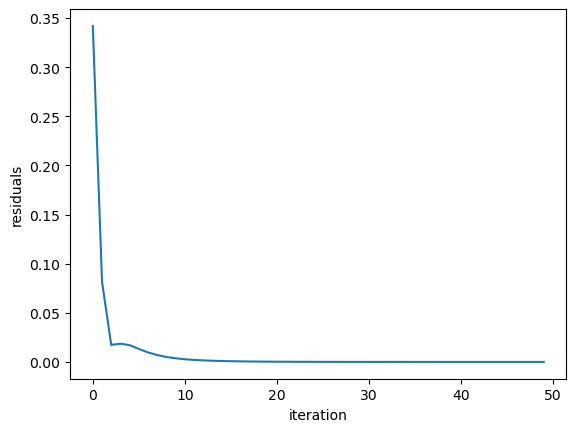

In [102]:
import matplotlib.pyplot as plt

plt.plot(result["r_history"])
plt.xlabel("iteration")
plt.ylabel("residuals")
plt.show()

## Compute the objective value

In [133]:
def admm_final_objective(gamma_list, theta_list, x_list, z_list, zeta):
    N = len(gamma_list)

    quad = 0.0

    for i in range(N):
        diff = x_list[i] - theta_list[i]
        quad += diff @ (gamma_list[i] @ diff) # compute (x-theta)^T@Gamma@(x-theta)

    # compute l1 term
    z_sum = sum(z_list) #vectors in R^p of (g(sum(z_i)))
    l1 = zeta * np.linalg.norm(z_sum, 1) # norm 1

    return quad + l1

In [135]:
obj_admm_ = admm_final_objective(gamma_list, theta_list, result["x"], result["z_blocks"], zeta=1.0)
print("Final admm objective result for the global minimization problem:", obj_admm_)

Final admm objective result for the global minimization problem: 1.850209926023066


## Compare with the build in library
## Test with OSQP and CVXOPT AND MOSEK

In [138]:
# usign the cvx py

In [212]:
# !pip install cvxpy

In [214]:
# !pip install --upgrade gensim gpy

In [146]:
import cvxpy as cp

In [184]:
print(cp.installed_solvers())

['CLARABEL', 'CVXOPT', 'GLPK', 'GLPK_MI', 'OSQP', 'SCIPY', 'SCS']


In [218]:
def solver_cvxpy_osqp(gamma_list, theta_list, zeta):
    N = len(gamma_list)
    p = theta_list[0].shape[0]

    # set the optimize variable
    x = [cp.Variable(p) for _ in range(N)]
    z = [cp.Variable(p) for _ in range(N)]

    #objective
    quad_term = []

    for i in range(N):
        diff = x[i] - theta_list[i]
        quad_term.append(cp.quad_form(diff, gamma_list[i])) # (x-theta) @ Gamma @ (x-theta)

    z_sum = sum(z)
    l1_term = zeta * cp.norm1(z_sum) #l1 term

    obj = cp.Minimize(cp.sum(quad_term) + l1_term)

    #set constraints x_i = z_i
    constrains = [x[i] == z[i] for i in range(N)]

    prob = cp.Problem(obj, constrains) #define problems
    prob.solve(solver=cp.OSQP) #using solver osqp to solve problem - OSQP using ADMM

    x_val = [xi.value for xi in x]
    z_val = [zi.value for zi in z]
    
    return prob.value, x_val, z_val, prob.solver_stats

In [220]:
obj_cvxpy_osqp, x_cvsxpy_osqp, z_cvxpy_osqp, cvxpy_osqp_solver_stats  = solver_cvxpy_osqp(gamma_list, theta_list, zeta=1.0)

In [222]:
print("CVXPy objective with OSQP solver:", obj_cvxpy_osqp)

CVXPy objective with OSQP solver: 1.8502098701548788


In [164]:
print("Gap between own ADMM vs OSQP sovlver:", obj_admm_ - obj_cvxpy_osqp)

Gap between own ADMM vs OSQP sovlver: 5.5868187187613216e-08


In [230]:
print("Number of the iteration:", cvxpy_osqp_solver_stats.num_iters)
print("Primal res:", cvxpy_osqp_solver_stats.extra_stats.info)

Number of the iteration: 50
Primal res: namespace(_pybind11_conduit_v1_=<bound method pybind11_detail_function_record_v1_msvc_md_mscver19._pybind11_conduit_v1_ of <osqp.ext_builtin.OSQPInfo object at 0x000001C146F3F530>>, status='solved', status_val=1, status_polish=1, obj_val=1.8502098701548786, prim_res=1.942890293094024e-16, dual_res=3.7674056849830153e-16, iter=50, rho_updates=0, rho_estimate=0.22619514674408864, setup_time=9.41e-05, solve_time=0.0001006, update_time=0.0, polish_time=5.75e-05, run_time=0.0002522)


### CVXOPT

In [174]:
!pip install cvxopt

   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
    --------------------------------------- 0.3/12.8 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.8 MB 2.1 MB/s eta 0:00:06
   --- ------------------------------------ 1.0/12.8 MB 2.1 MB/s eta 0:00:06
   ---- ----------------------------------- 1.6/12.8 MB 2.2 MB/s eta 0:00:06
   ------ --------------------------------- 2.1/12.8 MB 2.3 MB/s eta 0:00:05
   -------- ------------------------------- 2.9/12.8 MB 2.4 MB/s eta 0:00:05
   ---------- ----------------------------- 3.4/12.8 MB 2.4 MB/s eta 0:00:04
   ----------- ---------------------------- 3.7/12.8 MB 2.4 MB/s eta 0:00:04
   ------------- -------------------------- 4.5/12.8 MB 2.5 MB/s eta 0:00:04
   --------------- ------------------------ 5.0/12.8 MB 2.5 MB/s eta 0:00:04
   ----------------- ---------------------- 5.8/12.8 MB 2.6 MB/s eta 0:00:03
   -------------------- ------------------- 6.6/12.8 MB 2.7 MB/s eta 0:00:03
   ----------

In [208]:
# Compare the result with another method
import cvxopt 
print(cvxopt.__version__)

def solver_cvxpy_cvxopt(gamma_list, theta_list, zeta):
    N = len(gamma_list)
    p = theta_list[0].shape[0]

    # set the optimize variable
    x = [cp.Variable(p) for _ in range(N)]
    z = [cp.Variable(p) for _ in range(N)]

    #objective
    quad_term = []

    for i in range(N):
        diff = x[i] - theta_list[i]
        quad_term.append(cp.quad_form(diff, gamma_list[i])) # (x-theta) @ Gamma @ (x-theta)

    z_sum = sum(z)
    l1_term = zeta * cp.norm1(z_sum) #l1 term

    obj = cp.Minimize(cp.sum(quad_term) + l1_term)

    #set constraints x_i = z_i
    constrains = [x[i] == z[i] for i in range(N)]

    prob = cp.Problem(obj, constrains) #define problems
    prob.solve(solver=cp.CVXOPT) #using solver osqp to solve problem - OSQP using ADMM

    x_val = [xi.value for xi in x]
    z_val = [zi.value for zi in z]

    return prob.value, x_val, z_val

1.3.2


In [235]:
# obj_cvxpy_cvxopt, x_cvsxpy_cvxopt, z_cvxpy_cvxopt = solver_cvxpy_cvxopt(gamma_list, theta_list, zeta=1.0)

In [ ]:
print("CVXPy objective with CVXOPT solver:", obj_cvxpy_cvxopt)

In [ ]:
print("Gap between own ADMM vs CVXOPT sovlver:", obj_admm_ - obj_cvxpy_cvxopt)

## Try with a different stoping criteria

In [233]:
class Sharing_ADMM_L1Norm_V2:
    def __init__(self, gamma_list, theta_list, zeta=1.0, rho=1.0, eps_abs=1e-4, eps_rel=1e-3, max_iters=300):
        """
        input: 
        + gamma: list of pxp PSD matrix
        + theta: coresponding theta
        + zeta: l1 weight
        + rho: penalty for the augumented part
        """
        self.N = len(gamma_list)
        assert self.N == len(theta_list), "number of theta and gamma missmach"
        self.p = theta_list[0].shape[0] #dimension input

        #store data
        self.G = [np.array(Gi, dtype=float) for Gi in gamma_list]
        self.theta = [np.array(ti, dtype=float).reshape(-1) for ti in theta_list]
        self.residual_storage = []

        # hyper-params:
        self.zeta = float(zeta)
        self.rho = float(rho)
        self.eps_abs  = float(eps_abs)
        self.eps_rel  = float(eps_rel)
        self.max_iters = int(max_iters)

        # variable:
        self.x = [np.zeros(self.p) for _ in range(self.N)] #store solution each iteration
        self.z_blocks = [np.zeros(self.p) for _ in range(self.N)] #set the z as zeros so we basically can using
        # the form of the mean for z update naturally at the first place but if not -> we need to do the first iteration
        # for update the x based on the modeling 
        self.u_shared = np.zeros(self.p) #used when k >= 1 

        self.u_blocks0 = [np.zeros(self.p) for _ in range(self.N)] #use only for k = 0

        self.z_global = np.zeros(self.p) #aggregated z

        # does not change the rho so we can store the cholesky decomp
        I = np.eye(self.p)
        self.L = []

        for i in range(self.N):
            Ai = 2.0 * self.G[i] + self.rho * I ## as when solving the linear system of the optimizing the x
            self.L.append(np.linalg.cholesky(Ai))

    # since the admm with the random initialize of the 
    def first_iter(self):
        # at the first iteration the update of x with the average value will not suitable hence we will optimize the x_i through normal
        N, rho = self.N, self.rho

        # x^i(k+1) -> sovlve (2G + rho*I)@x^k = 2G * theta + rho*(z_ik - u_ik)
        for i in range(N):
            rhs = 2.0 * self.G[i] @ self.theta[i] + rho * (self.z_blocks[i] - self.u_blocks0[i])
            self.x[i] = cho_solve(self.L[i], rhs) #apply cho solve to solve the linear system

        #calculate the z_bar
        a = [self.x[i] + self.u_blocks0[i] for i in range(N)]
        a_bar = sum(a) / N

        # adapt the soft thresholding to solve the proximal problem
        tau = self.zeta / rho
        self.z_global = soft_threshold(a_bar, tau)

        for i in range(N):
            self.z_blocks[i] = a[i] + (self.z_global - a_bar) # calculate each z_ik after solving the minimizer of g(n*z_bar) (7.13)

        self.u_shared = a_bar - self.z_global #update the global multiplier


    def step(self):
        """Continue with the x update using the mean formular"""
        N, rho = self.N, self.rho

        # x_update -> solve: (2*G + rho*I)@x_k+1 = 2*G@theta + rho(x_ik + z_bar_k - x_bar_k - u_bar_k)
        x_bar = sum(self.x)/N

        for i in range(N):
            rhs = 2.0 * self.G[i] @ self.theta[i] + rho * (self.x[i] + self.z_global - x_bar - self.u_shared)
            self.x[i] = cho_solve(self.L[i], rhs) #solving linear system for update x_i(k+1)

        #update z^(k+1): prox the average of a_i = x_i^k+1 + u^k
        a = [self.x[i] + self.u_shared for i in range(N)] #using ushare since all the agetns shared the same u
        a_bar = sum(a) / N

        #update the z_bar same as before
        tau = self.zeta / rho
        self.z_global = soft_threshold(a_bar, tau)

        #recover the block z_i for each agents
        for i in range(N):
            self.z_blocks[i] = a[i] + (self.z_global - a_bar)

        self.u_shared = a_bar - self.z_global

    def residuals_mean(self, z_global_prev):
        # adapt the mean based stoping criteria as
        # Paper: Optimal querying for communication-efficient ADMM using Gaussian process regression
        N, rho = self.N, self.rho

        x_bar = sum(self.x) / N             # shape (p,)
        z_bar = self.z_global               # shape (p,)

        r = np.linalg.norm(x_bar - z_bar, 2)
        s = rho * np.linalg.norm(z_bar - z_global_prev, 2)

        xbar_norm = np.linalg.norm(x_bar, 2)
        zbar_norm = np.linalg.norm(z_bar, 2)

        # tolerances refine
        eps_pri = (self.p ** 0.5) * self.eps_abs + self.eps_rel * max(xbar_norm, zbar_norm)
        eps_dual = (self.p ** 0.5) * self.eps_abs + self.eps_rel * zbar_norm

        return r, s, eps_pri, eps_dual

    def solve(self, verbose=True, log_every=1):
        N, p = self.N, self.p

        # k = 0 step
        self.first_iter()

        # for mean-based dual residual, we need previous z_bar
        z_bar_prev = np.zeros_like(self.z_global)

        r, s, eps_pri, eps_dual = self.residuals_mean(z_bar_prev)
        self.residual_storage.append(r)

        if verbose:
            print(f"iter 0: r={r:.3e} - eps_pri {eps_pri:.2e} and s={s:.3e} eps_dual - {eps_dual:.2e}")

        if r <= eps_pri and s <= eps_dual:
            return {
                "iters": 0,
                "r": r,
                "s": s,
                "eps_pri": eps_pri,
                "eps_dual": eps_dual,
                "x": [xi.copy() for xi in self.x],
                "z_blocks": [zi.copy() for zi in self.z_blocks],
                "z_global": self.z_global.copy(),
                "u": self.u_shared.copy(),
                "rho": self.rho,
                "zeta": self.zeta,
                "N": self.N,
                "p": self.p,
                "r_history": self.residual_storage,
            }

        # k >= 1
        for k in range(1, self.max_iters + 1):
            z_bar_prev = self.z_global.copy()

            self.step()

            r, s, eps_pri, eps_dual = self.residuals_mean(z_bar_prev)
            self.residual_storage.append(r)

            if verbose and (k % log_every == 0 or (r <= eps_pri and s <= eps_dual)):
                print(f"iter {k}: r={r:.3e} - eps_pri {eps_pri:.2e} and s={s:.3e} eps_dual - {eps_dual:.2e}")

            if r <= eps_pri and s <= eps_dual:
                return {
                    "iters": k,
                    "r": r,
                    "s": s,
                    "eps_pri": eps_pri,
                    "eps_dual": eps_dual,
                    "x": [xi.copy() for xi in self.x],
                    "z_blocks": [zi.copy() for zi in self.z_blocks],
                    "z_global": self.z_global.copy(),
                    "u": self.u_shared.copy(),
                    "rho": self.rho,
                    "zeta": self.zeta,
                    "N": self.N,
                    "p": self.p,
                    "r_history": self.residual_storage,
                }

        # max iters
        return {
            "iters": self.max_iters,
            "r": r,
            "s": s,
            "eps_pri": eps_pri,
            "eps_dual": eps_dual,
            "x": [xi.copy() for xi in self.x],
            "z_blocks": [zi.copy() for zi in self.z_blocks],
            "z_global": self.z_global.copy(),
            "u": self.u_shared.copy(),
            "rho": self.rho,
            "zeta": self.zeta,
            "N": self.N,
            "p": self.p,
            "r_history": self.residual_storage,
        }

In [237]:
N = 10
gamma_list = [gamma[i] for i in range(N)]      
theta_list = [theta[i].reshape(-1) for i in range(N)]

solver = Sharing_ADMM_L1Norm_V2(gamma_list, theta_list, zeta=1.0, rho=10, eps_abs=1e-6, eps_rel=1e-4, max_iters=250)

result_admmV2 = solver.solve(
    verbose=True,
    log_every=1
)

print("\n--- finised ---")
print("iters V2:", result_admmV2["iters"])
print("r_v2:", result_admmV2["r"], " (<= eps_pri:", result_admmV2["eps_pri"], ")")
print("s_v2:", result_admmV2["s"], " (<= eps_dual:", result_admmV2["eps_dual"], ")")
print("z_global:", result_admmV2["z_global"])

iter 0: r=1.082e-01 - eps_pri 1.31e-05 and s=0.000e+00 eps_dual - 2.24e-06
iter 1: r=2.581e-02 - eps_pri 4.82e-06 and s=0.000e+00 eps_dual - 2.24e-06
iter 2: r=5.479e-03 - eps_pri 2.78e-06 and s=0.000e+00 eps_dual - 2.24e-06
iter 3: r=5.861e-03 - eps_pri 2.82e-06 and s=0.000e+00 eps_dual - 2.24e-06
iter 4: r=5.400e-03 - eps_pri 2.78e-06 and s=0.000e+00 eps_dual - 2.24e-06
iter 5: r=4.188e-03 - eps_pri 2.65e-06 and s=0.000e+00 eps_dual - 2.24e-06
iter 6: r=3.060e-03 - eps_pri 2.54e-06 and s=0.000e+00 eps_dual - 2.24e-06
iter 7: r=2.203e-03 - eps_pri 2.46e-06 and s=0.000e+00 eps_dual - 2.24e-06
iter 8: r=1.592e-03 - eps_pri 2.40e-06 and s=0.000e+00 eps_dual - 2.24e-06
iter 9: r=1.165e-03 - eps_pri 2.35e-06 and s=0.000e+00 eps_dual - 2.24e-06
iter 10: r=8.656e-04 - eps_pri 2.32e-06 and s=0.000e+00 eps_dual - 2.24e-06
iter 11: r=6.521e-04 - eps_pri 2.30e-06 and s=0.000e+00 eps_dual - 2.24e-06
iter 12: r=4.971e-04 - eps_pri 2.29e-06 and s=0.000e+00 eps_dual - 2.24e-06
iter 13: r=3.828e-04 -

In [239]:
result_admmV2["x"]

[array([ 0.15772046, -0.57314188, -0.97576885,  0.5003705 , -0.14849763]),
 array([-0.13889426,  0.08996434,  0.94403514,  0.05512709, -0.27775138]),
 array([ 0.02048266, -0.1378417 ,  1.13588574, -0.66972466,  0.68229417]),
 array([ 0.46342287,  0.22405133, -0.56666331,  0.23508471,  0.22490621]),
 array([ 0.29590739, -0.8992043 ,  0.84503383, -0.35162886, -0.94310653]),
 array([-0.51115229,  0.56645496,  0.7466853 , -0.40372833, -0.00803759]),
 array([ 0.43326404,  0.8377014 , -0.60982381,  0.00896806,  0.54080419]),
 array([-0.18138257, -0.09747008, -0.65475042,  0.27119469, -0.83313256]),
 array([-0.38645531, -0.12150257, -0.59980117,  0.31597987,  0.90673119]),
 array([-0.15290673,  0.11099322, -0.26481553,  0.03835635, -0.14420649])]

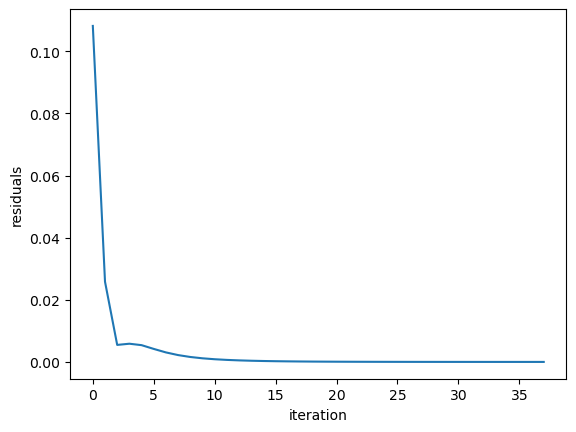

In [241]:
import matplotlib.pyplot as plt

plt.plot(result_admmV2["r_history"])
plt.xlabel("iteration")
plt.ylabel("residuals")
plt.show()

In [243]:
obj_admm_V2 = admm_final_objective(gamma_list, theta_list, result_admmV2["x"], result_admmV2["z_blocks"], zeta=1.0)
print("Final admm objective result for the global minimization problem:", obj_admm_V2)

Final admm objective result for the global minimization problem: 1.8502130251583966


In [247]:
print("Gap between own ADMM vs ADMMV2 sovlver:", obj_admm_ - obj_admm_V2)
print("Gap between own ADMMv2 vs OSQP sovlver:", obj_cvxpy_osqp - obj_admm_V2)

Gap between own ADMM vs ADMMV2 sovlver: -3.0991353305864777e-06
Gap between own ADMMv2 vs OSQP sovlver: -3.155003517774091e-06
